In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset_train = datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # first, convert image to PyTorch tensor
                                                               # normalize inputs
                                                          ]))
dataset_test = datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]))

In [3]:

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trn_BATCH_SIZE = 4
test_BATCH_SIZE = 100



trainloader = torch.utils.data.DataLoader(datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),
                                           
                                           batch_size=trn_BATCH_SIZE, 
                                           shuffle=True)




# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),  
                                           
                                           batch_size=test_BATCH_SIZE, 
shuffle=True)

In [4]:
visualise_target = dataset_train.targets
visualise_data = dataset_train.data

# Lets visualise image in train set 
We take a random index and plot the img pixels using imshow() we reshape the data to a 28x28 matrix


tensor([7])


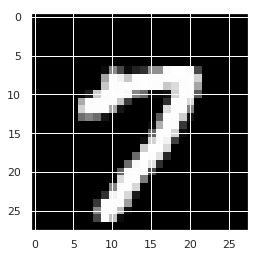

In [5]:
random_generated_number = torch.LongTensor(1).random_(0,len(dataset_test.targets))
img_pixel  = visualise_data[random_generated_number]
img_label = visualise_target[random_generated_number]
plt.imshow(img_pixel.reshape(28,28),cmap="gray")
print(img_label)

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

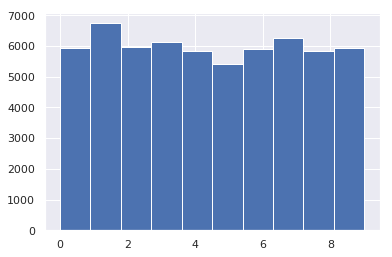

In [6]:
plt.hist(visualise_target)

 This is a count plot of number distributions in image were image of number '1' been the highest around 6800 and number 5 is lowest, Even though the distribution is uneven we can still train out model efficently 


# Code for activation funtions

activation funtions are resposible to add non linearity to layers as, linear models are not good at handling classification data
We first  define sigmoid funtion which will convert any given number in range between 0 - 1.
Then we defined derivative of sigmoid funtion, that we will use later while calculating cost funtions
At last Softmax funtions that will convert the input tensors to a probablity distribution for each number.

In [7]:

def sigmoid(z):
    """Calculates sigmoid values for tensors

    """
    result = 1.0 / (1 + torch.exp(-z))
    return result

""" The derivative of sigmoid can be written as exp(-z) * ( 1 / (1 + exp(-z)**2))
    on further simplifying (subraction of inner bracket value by 1 and taking sigmoid funtion common) 
    we get sigmoid(1 - sigmoid)"""
def delta_sigmoid(z):
    """Calculates derivative of sigmoid function

    """
    grad_sigmoid = sigmoid(z) * ( 1 - sigmoid(z))
    return grad_sigmoid

""" The Softmax outputs 0 or near zero value when overflow of exp occurs
    to tackle this we add a constant c to parameter and pass to funtion
    subracting max value from parameter leaves only the non-positive entries,
    thus ruling out overflow problem"""
def softmax(x):
    """Calculates stable softmax (minor difference from normal softmax) values for tensors

    """
    m = x.shape[0]
    z = x - torch.max(x)
    numerator = torch.exp(z)
    denominator = torch.sum(numerator,1)
    stable_softmax = numerator/denominator.reshape(m,1)
  
    return stable_softmax


# Code for loss funtion 'Cross entropy loss',
We have used our loss funtion of cross entropy loss for multiclass classification.


In [8]:
def cross_entropy_loss(outputs, labels):
    """Calculates cross entropy loss given outputs and actual labels

    """ 
    """One hot ending for labels and output reshaping"""
    
    m = outputs.shape[0]
    n = outputs.shape[1]
    temp_labels = torch.zeros(m,n)
    for i in range(m):
        temp_labels[i][labels[i]] = 1
    creloss = -(1/m)*torch.sum( temp_labels * torch.log(outputs)  )


    return creloss.item()   # should return float not tensor

    
"""We calculated the derivative of negetive likehood w.r.t to softmax and multiplied it
   with  derivative of softmax w.r.t to output from last previous activation funtion"""  
    
def delta_cross_entropy_softmax(outputs, labels):
    """Calculates derivative of cross entropy loss (C) w.r.t. weighted sum of inputs (Z). 
    
    """
    
    '''processing labels(One-hot encoding) and outputs(resizing) argument  '''
    m = outputs.shape[0]
    n = outputs.shape[1]
    
    temp_labels = torch.zeros(m,n)
    for i in range(m):
        temp_labels[i][labels[i]] = 1
    
    avg_grads = outputs - temp_labels
    
    return avg_grads*(1/m)


# Code for updating parameter.
We then,update neural network parameter(weight and baises) after the gradients are recived from backpropagation

In [9]:

""" Updating weights by subracting the product of cost derivative w.r.t to parameters
     and learning rate"""

def mbgd(weights, biases, dw1, db1, dw2, db2, dw3, db3, lr):
    """Mini-batch gradient descent
    """
    new_weights = {'w1':0,'w2':0,'w3':0}
    new_biases = {'b1':0,'b2':0,'b3':0}
    new_weights['w1'] = weights['w1'] - lr * dw1
    new_weights['w2'] = weights['w2'] - lr * dw2
    new_weights['w3'] = weights['w3'] - lr * dw3
    new_biases['b1'] =  biases['b1'] - lr * db1
    new_biases['b2'] = biases['b2'] - lr * db2
    new_biases['b3'] = biases['b3'] - lr * db3

    return new_weights, new_biases


# Code for neural network model.
Then we code a fully connected neural network, in the model we have the following layer:
        
        1.Input layer : dataset(784)
        
        2.Hidden Layer1 :(256) input from layer 1 passed to a linear funtion, activation funtion used: sigmoid(to apply non linearity)
        
        3.Hidden Layer2 :(256) input from layer 2 passed to a linear funtion, activation funtion used: sigmoid(to apply non linearity)
        
        4.Output Layer :(10) input from layer 3 passed to a linear funtion, activation funtion used: softmax(to get probablity for every number)

In [10]:
# import math
import torch

class FullyConnected:
    """Constructs the Neural Network architecture.

    Args:
        N_in (int): input size
        N_h1 (int): hidden layer 1 size
        N_h2 (int): hidden layer 2 size
        N_out (int): output size
        device (str, optional): selects device to execute code. Defaults to 'cpu'
    
    Examples:
        >>> network = model.FullyConnected(2000, 512, 256, 5, device='cpu')
        >>> creloss, accuracy, outputs = network.train(inputs, labels)
    """

    def __init__(self, N_in, N_h1, N_h2, N_out, device='cpu'):
        """Initializes weights and biases, and construct neural network architecture.
        
        One [recommended](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) approach is to initialize weights randomly but uniformly in the interval from [-1/n^0.5, 1/n^0.5] where 'n' is number of neurons from incoming layer. For example, number of neurons in incoming layer is 784, then weights should be initialized randomly in uniform interval between [-1/784^0.5, 1/784^0.5].
        
        You should maintain a list of weights and biases which will be initalized here. They should be torch tensors.

        Optionally, you can maintain a list of activations and weighted sum of neurons in a dictionary named Cache to avoid recalculation of those. If tensors are too large it could be an issue.
        """
        self.N_in = N_in
        self.N_h1 = N_h1
        self.N_h2 = N_h2
        self.N_out = N_out

        self.device = torch.device(device)

        w1 = torch.Tensor(N_h1,N_in).uniform_(-1/math.pow(N_in,0.5), 1/math.pow(N_in,0.5)).float()
        w2 = torch.Tensor(N_h2,N_h1).uniform_(-1/math.pow(N_h1,0.5), 1/math.pow(N_h1,0.5)).float()
        w3 = torch.Tensor(N_out,N_h2).uniform_(-1/math.pow(N_h2,0.5), 1/math.pow(N_h2,0.5)).float()
        self.weights = {'w1': w1, 'w2': w2, 'w3': w3}
              
        b1 = torch.Tensor(N_h1).uniform_(-1/math.pow(N_in,0.5), 1/math.pow(N_in,0.5)).float()
        b2 = torch.Tensor(N_h2).uniform_(-1/math.pow(N_h1,0.5), 1/math.pow(N_h1,0.5)).float()
        b3 = torch.Tensor(N_out).uniform_(-1/math.pow(N_h2,0.5), 1/math.pow(N_h2,0.5)).float()
        self.biases = {'b1': b1, 'b2': b2, 'b3': b3}
        
        self.cache = {'z1': 0, 'z2': 0, 'z3': 0,'a1':0, 'a2' : 0 , 'a3' : 0}

    def train(self, inputs, labels, lr=0.001, debug=False):
        """Trains the neural network on given inputs and labels.

        This function will train the neural network on given inputs and minimize the loss by backpropagating and adjusting weights with some optimizer.

        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 
            labels (torch.tensor): correct labels. Size (batch_size)
            lr (float, optional): learning rate for training. Defaults to 0.001
            debug (bool, optional): prints loss and accuracy on each update. Defaults to False

        Returns:
            creloss (float): average cross entropy loss
            accuracy (float): ratio of correctly classified to total samples
            outputs (torch.tensor): predictions from neural network. Size (batch_size, N_out)
        """
        """This condition is for training on train set as the validation set
            should not be trained, so we applied check condition(debug)
            debug : True -> validation set
            debug : False -> trainset
            The for loop will take samples from minibatch and train the network"""
            
        outputs = self.forward(inputs)
        dw1, db1, dw2, db2, dw3, db3 = self.backward(inputs, labels, outputs)
        self.weights, self.biases = mbgd(self.weights, self.biases, dw1, db1, dw2, db2, dw3, db3, lr)
        creloss = cross_entropy_loss(outputs,labels)
        accuracy = self.accuracy(outputs,labels)
         
        
        if debug:
            print('Training loss ',creloss)
            print('training accuracy: ',accuracy*100,'%')
          
         
        
        return creloss,accuracy, outputs.type(torch.FloatTensor)

    def predict(self, inputs):
        """Predicts output probability and index of most activating neuron

        This function is used to predict output given inputs. You can then use index in classes to show which class got activated. For example, if in case of MNIST fifth neuron has highest firing probability, then class[5] is the label of input.

        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 

        Returns:
            score (torch.tensor): max score for each class. Size (batch_size)
            idx (torch.tensor): index of most activating neuron. Size (batch_size)  
        """
        outputs = self.forward(inputs) # forward pass
        
        score , idx = torch.max(outputs,1)[0],torch.argmax(outputs,1)
        return score.type(torch.FloatTensor), idx.type(torch.LongTensor)

    def eval(self, inputs, labels, debug=False):
        """Evaluate performance of neural network on inputs with labels.

        This function is used to evaluate loss and accuracy of neural network on new examples. Unlike predict(), this function will not only predict but also calculate and return loss and accuracy w.r.t given inputs and labels.

        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 
            labels (torch.tensor): correct labels. Size (batch_size)
            debug (bool, optional): print loss and accuracy on every iteration. Defaults to False

        Returns:
            loss (float): average cross entropy loss
            accuracy (float): ratio of correctly to uncorrectly classified samples
            outputs (torch.tensor): predictions from neural network. Size (batch_size, N_out)
        """
        """We first take the average of loss and accuracy of every batch and 
            return"""
        temp_cre = 0
        temp_acc = 0
        outputs = 0
        m = inputs.shape[0]
        outputs = self.forward(inputs)
        for i in range(m):
            temp_cre += cross_entropy_loss(outputs[i].reshape(1,-1),labels[i])
            temp_acc += self.accuracy(outputs[i].reshape(1,-1),labels[i])
         
            if debug:
                print('loss: ', temp_cre/(i+1))
                print('accuracy: ', temp_acc*100/(i+1))
        return temp_cre/m, temp_acc*100/m, outputs

    def accuracy(self, outputs, labels):
        """Accuracy of neural network for given outputs and labels.
        
        Calculates ratio of number of correct outputs to total number of examples.

        Args:
            outputs (torch.tensor): outputs predicted by neural network. Size (batch_size, N_out)
            labels (torch.tensor): correct labels. Size (batch_size)
        
        Returns:
            accuracy (float): accuracy score 
        """
        """The index with the max value in output tensor will be 
            considered as number prediction from the trained network
            then it is compared with the label and the correct numbers are 
            incremented, at last we average the corrrect prediction"""
        correct = 0
        m = outputs.shape[0]
        for i in range(m):
            temp = torch.argmax(outputs[i])
            if (temp.item() == labels[i].item()):
                correct+=1
        accuracy = correct/m
        return accuracy

    def forward(self, inputs):
        """Forward pass of neural network

        Calculates score for each class.

        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 

        Returns:
            outputs (torch.tensor): predictions from neural network. Size (batch_size, N_out)
        """
        """The linear outputs are first calculated at every layer then a 
            non linear funtion is applied to it and stored in cache for furter use"""
        self.cache['z1'] = self.weighted_sum(inputs,self.weights['w1'],self.biases['b1'])
        a1 = sigmoid(self.cache['z1'])
        self.cache['z2'] = self.weighted_sum(a1,self.weights['w2'],self.biases['b2']) 
        a2 = sigmoid(self.cache['z2'])
        self.cache['z3'] = self.weighted_sum(a2,self.weights['w3'],self.biases['b3'])
        
        outputs = softmax(self.cache['z3']) 
        self.cache['a1'] = a1
        self.cache['a2'] = a2
        self.cache['a3'] = outputs
        
        return outputs

    def weighted_sum(self, X, w, b):
        """Weighted sum at neuron
        
        Args:
            X (torch.tensor): matrix of Size (K, L)
            w (torch.tensor): weight matrix of Size (J, L)
            b (torch.tensor): vector of Size (J)

        Returns:
            result (torch.tensor): w*X + b of Size (K, J)
        """
        mm = torch.mm(X,w.t())
        result = torch.add(mm,b)
        return result

    def backward(self, inputs, labels, outputs):
        """Backward pass of neural network
        
        Changes weights and biases of each layer to reduce loss
        
        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 
            labels (torch.tensor): correct labels. Size (batch_size)
            outputs (torch.tensor): outputs predicted by neural network. Size (batch_size, N_out)
        
        Returns:
            dw1 (torch.tensor): Gradient of loss w.r.t. w1. Size like w1
            db1 (torch.tensor): Gradient of loss w.r.t. b1. Size like b1
            dw2 (torch.tensor): Gradient of loss w.r.t. w2. Size like w2
            db2 (torch.tensor): Gradient of loss w.r.t. b2. Size like b2
            dw3 (torch.tensor): Gradient of loss w.r.t. w3. Size like w3
            db3 (torch.tensor): Gradient of loss w.r.t. b3. Size like b3
        """
        # Calculating derivative of loss w.r.t weighted sum
        """Calculating error to loss from outputs and labels"""
        dout = delta_cross_entropy_softmax(outputs , labels)
        """Second layer error"""
        d2 = torch.mm(dout , self.weights['w3']) * delta_sigmoid(self.cache['z2'])
        """First layer error"""
        d1 = torch.mm(d2 , self.weights['w2'] ) * delta_sigmoid(self.cache['z1'])
        
        """Gradients for after backpropogation """
        dw1, db1, dw2, db2, dw3, db3 = self.calculate_grad(inputs, d1, d2, dout)# calculate all gradients
        return dw1, db1, dw2, db2, dw3, db3

    def calculate_grad(self, inputs, d1, d2, dout):
        """Calculates gradients for backpropagation
        
        This function is used to calculate gradients like loss w.r.t. weights and biases.

        Args:
            inputs (torch.tensor): inputs to train neural network. Size (batch_size, N_in) 
            dout (torch.tensor): error at output. Size like aout or a3 (or z3)
            d2 (torch.tensor): error at hidden layer 2. Size like a2 (or z2)
            d1 (torch.tensor): error at hidden layer 1. Size like a1 (or z1)

        Returns:
            dw1 (torch.tensor): Gradient of loss w.r.t. w1. Size like w1
            db1 (torch.tensor): Gradient of loss w.r.t. b1. Size like b1
            dw2 (torch.tensor): Gradient of loss w.r.t. w2. Size like w2
            db2 (torch.tensor): Gradient of loss w.r.t. b2. Size like b2
            dw3 (torch.tensor): Gradient of loss w.r.t. w3. Size like w3
            db3 (torch.tensor): Gradient of loss w.r.t. b3. Size like b3
        """
        """Updating weight gradients (dependent of previous layers)"""
        
        dw3 = torch.mm(dout.t(),self.cache['a2'])
        dw2 = torch.mm(d2.t() , self.cache['a1']) 
        dw1 = torch.mm(d1.t() , inputs)
        
        """Updating baises gradients (independent for previous layer)
            flatten method is used for 1D conversion"""
        db3 = torch.sum(dout ,0, True).flatten()
        db2 = torch.sum(d2 ,0, True).flatten() 
        db1 = torch.sum(d1 ,0, True).flatten() 
        return dw1, db1, dw2, db2, dw3, db3



# Setting up the hyper parameter to construct our neural network 


In [11]:
# Layer size
N_in = 28 * 28 # Input size
N_h1 = 256 # Hidden Layer 1 size
N_h2 = 256 # Hidden Layer 2 size
N_out = 10 # Output size
# Learning rate
lr = 0.001


# The warning supressor was used as to supress the .item() warning from python, as from  pytorch 0.5 the retirival for retriving data we have to compulory use .item() method,But this will cause no problem to our model therefore we decided to supress it.

In [12]:
net = FullyConnected(N_in, N_h1, N_h2, N_out, device=device)
N_epoch = 2 

#This parameter wil decide wheather to show training accuracy and loss on every iteration(Default has been set to False, as to make things look cleaner)
debug = False

# Instead of slipting validation set from training set we set a condition check to auto filter data for validation set we set check to 5 as the total iteration in one epoch will be (60000/4) = 15000 and every 5th batch will be a validation batch so total training dataset is been split into 80/20 ratio with validation set as 12000 and training as 48000 dataset.


In [13]:
import warnings
warnings.filterwarnings("ignore")
loss_train = []
loss_valid = []
acc_train = []
acc_valid = []
temp_idx = 0
temp_idx1 = 0
for i in range(N_epoch):
    j = 0
    
    for batch_idx, (x, target) in enumerate(trainloader):
        j+=1
        x, target = x, target
        x = x.reshape(trn_BATCH_SIZE,-1)
        if (j%5!=0):
            temp_idx+=1
            creloss, accuracy, outputs = net.train(x, target, lr=0.01,debug=False)
            if(temp_idx%1000 == 0):
                loss_train.append(creloss)
                acc_train.append(accuracy)
    j=0
    k=0
    
    """Validation Set"""
    validation_loss = validation_accuracy = 0
    for batch_idx, (x, target) in enumerate(trainloader):
        j+=1
        x, target = x, target
        x = x.reshape(trn_BATCH_SIZE,-1)
        if (j%5==0):
            k+=1
            temp_idx1+=1
            valid_loss,valid_acc,outputs = net.eval(x,target)
            validation_loss+=valid_loss
            validation_accuracy+=valid_acc
            if(temp_idx1%400 == 0):
                loss_valid.append(valid_loss)
                acc_valid.append(valid_acc)
            
    print('Epoch: ',i+1,' Validation loss ',validation_loss/k,' accuracy: ',validation_accuracy/k)


Epoch:  1  Validation loss  0.35903891126081  accuracy:  89.925
Epoch:  2  Validation loss  0.2588192576973015  accuracy:  92.35


The split in the validation was made as to overcome over fitting.
The model is designed to reduce the loss of training data, so it is obviouse given a right implementation, the loss in traing set will reduce and accuracy will increase on training set, but this will lead to overfitting(the model will be too much trained to recognise only previously seen data), so the solution is to make a small validation set from training data , that will validate wheather our model is overfitting or not, if the accuracy in the validation set is increasing the model is doing well.

From the above data we can make conclusions that our parameter initialization, and hyperparameters setting are correct, to make this model fit well and not overfit, as we have used mini batch SGD the common problem arises is the stucking of gradients at local minimma or saddle points but as our loss has decreased significantly we can conclude that our optimizer worked well at updating parameters, if you want to see loss decreasing live set debug to True and run the above block. 

Text(0.5,1,'Training loss ')

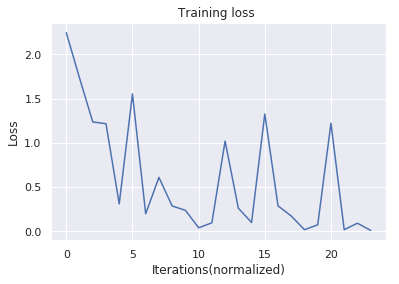

In [14]:
plt.plot(range(len(loss_train)) ,loss_train )
plt.xlabel('Iterations(normalized)')
plt.ylabel('Loss')
plt.title('Training loss ')

As per the curve the is seen to decrease steadily until the spike, the spike is generated because of gradient fluctuation as gradient desent won't decrease loss at every iteration,
as our funtion is not a perfect convex funtion spikes in loss is normal.

Text(0.5,1,'validation loss ')

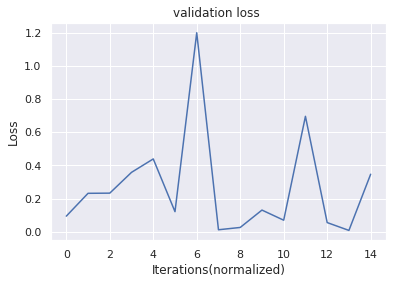

In [15]:
plt.plot(range(len(loss_valid)) ,loss_valid )
plt.xlabel('Iterations(normalized)')
plt.ylabel('Loss')
plt.title('validation loss ')

This is the validation loss curve as our model is trying to minimise training loss ,this set was introduced as to check over fitting but as the validation accuracy curve is steadily increasing(plotted below) we can conclude that our model is not overfitted, it is doing well on new data.

Text(0.5,1,'Training accuracy ')

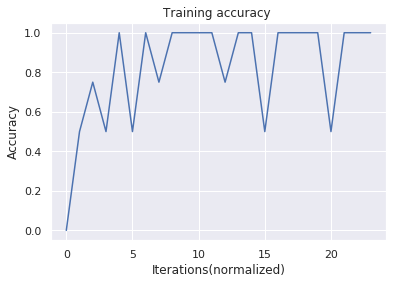

In [16]:
plt.plot(range(len(acc_train)) ,acc_train )
plt.xlabel('Iterations(normalized)')
plt.ylabel('Accuracy')
plt.title('Training accuracy ')

The fluctuation in training accuracy was caused by the fluctuaion in loss as explained in above markdown.
But as in last our model has around 100% accuracy.
This shows our model has trained well on training set.

Text(0.5,1,'Validation accuracy ')

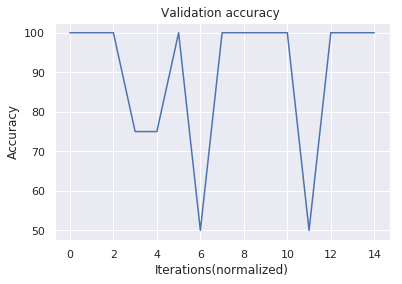

In [17]:
plt.plot(range(len(acc_valid)) ,acc_valid )
plt.xlabel('Iterations(normalized)')
plt.ylabel('Accuracy')
plt.title('Validation accuracy ')

This is the validation accuracy to check overfitting of model, as the accuracy curve is steadily incresing we can conclude that our model is doing fine on new data.
We can make our final assumption of accuracy on testing data.

# Test the model
As earlier we have created a seperate dataset, one the model has never seen before, and we will use this set to test our model for accuracy

In [18]:
accuracy_test = 0
j = 0
for batch_idx, (x, target) in enumerate(test_loader):
    j+=1
    x, target = x, target
    x = x.reshape(test_BATCH_SIZE,-1)
    score,idx = net.predict(x)
    accuracy_test += torch.sum( idx == target )
print('Test set accuray ',accuracy_test/j,'%')


Test set accuray  tensor(92) %


# Let's test  our model by visualizing results 

Actually we have our trained model, what we will do is pass some random data from test set and pass it through forward pass,
then plot the pixels(inputs) and see if the image matchs the label or not. 

Actual Value is  tensor([0])
Model predicts that probablity of image been number  tensor(0)  is  tensor(0.9975)


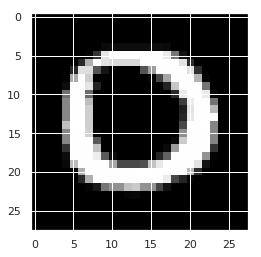

In [19]:
random_generated_image = torch.LongTensor(1).random_(0,len(dataset_test.targets))
test_visualise_data = dataset_test.data
test_visualise_target = dataset_test.targets
plt.imshow(test_visualise_data[random_generated_image].reshape(28,28),cmap="gray")
print('Actual Value is ',test_visualise_target[random_generated_image])
score,idx = net.predict(test_visualise_data[random_generated_image].type(torch.FloatTensor).reshape(1,-1))
print('Model predicts that probablity of image been number ',idx[0],' is ',score[0])

Actual Value is  tensor([1])
Model predicts that probablity of image been number  tensor(1)  is  tensor(0.9550)


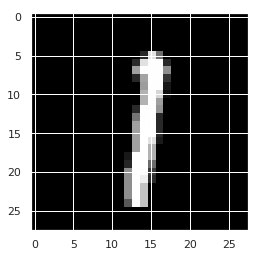

In [20]:
random_generated_image = torch.LongTensor(1).random_(0,len(dataset_test.targets))
test_visualise_data = dataset_test.data
test_visualise_target = dataset_test.targets
plt.imshow(test_visualise_data[random_generated_image].reshape(28,28),cmap="gray")
print('Actual Value is ',test_visualise_target[random_generated_image])
score,idx = net.predict(test_visualise_data[random_generated_image].type(torch.FloatTensor).reshape(1,-1))
print('Model predicts that probablity of image been number ',idx[0],' is ',score[0])

Actual Value is  tensor([5])
Model predicts that probablity of image been number  tensor(5)  is  tensor(0.7697)


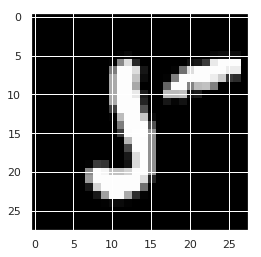

In [21]:
random_generated_image = torch.LongTensor(1).random_(0,len(dataset_test.targets))
test_visualise_data = dataset_test.data
test_visualise_target = dataset_test.targets
plt.imshow(test_visualise_data[random_generated_image].reshape(28,28),cmap="gray")
print('Actual Value is ',test_visualise_target[random_generated_image])
score,idx = net.predict(test_visualise_data[random_generated_image].type(torch.FloatTensor).reshape(1,-1))
print('Model predicts that probablity of image been number ',idx[0],' is ',score[0])

# As we saw the model is making great predictions on new data